In [1]:
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = 1

True
11721506816
0


In [2]:
my_path = '../dataset/sharma_59_nih_dataset/Image_dataset/'
path_0 = my_path+'0_0/'
path_1 = my_path + '1_1/'
print(len(os.listdir(path_0)))
print(len(os.listdir(path_1)))


# torchvision.transforms.Normalize(mean=torch.rand(3),std = torch.rand(3))
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

images = torchvision.datasets.ImageFolder(root=my_path,transform=transformations)
train_data,validate_data,test_data,extra = torch.utils.data.dataset.random_split(images,[8000,1500,2100,9733+9726-11600])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=True)


print(images.class_to_idx)

9733
9726
{'0_0': 0, '1_1': 1}


torch.Size([64, 3, 224, 224])
tensor(1.)


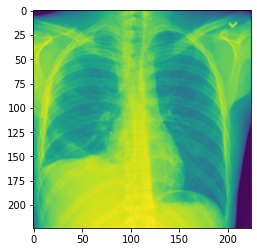

In [3]:
image,label = next(iter(train_loader))
print(image.shape)

print(torch.max(image))
plt.imshow(image[0][0])

In [8]:
print(x_train[0].shape, y_train[0].shape)
len(x_train),len(y_train)

(224, 224, 3) ()


(9600, 9600)

In [9]:
x_test = []
y_test = []
for a,b in test_dataset:
    x_test.append(a.numpy()[0])
    y_test.append(b.numpy()[0])
print(x_test[0].shape, len(y_test))

(224, 224, 3) 1600


In [10]:
x_val = []
y_val = []
for a,b in valid_dataset:
    x_val.append(a.numpy()[0])
    y_val.append(b.numpy()[0])


In [16]:
x_train,x_test,x_val = np.array(x_train), np.array(x_test), np.array(x_val)

# Training and testing of models


Mobile Net v2 model

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_augmentation = ImageDataGenerator(featurewise_center=True, rescale = 1/255.0,
                    featurewise_std_normalization=True, zoom_range=0.2,zca_whitening=True)
test_augmentation = ImageDataGenerator(rescale = 1/255.0)

In [ ]:
train_augmentation.fit(x_train)

In [17]:
test_augmentation.fit(x_test)


In [13]:
import tensorflow_hub as hub
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                   trainable=True),
    Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build([None, 224, 224, 3])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)


his = model.fit(train_augmentation.flow(x_train, y_train, batch_size=32),
         validation_data=test_augmentation.flow(x_val, y_val,
         batch_size=32),
         epochs=30, callbacks = [early_stop])

Epoch 1/30
300/300 [==============================] - 355s 1s/step - loss: 0.7222 - accuracy: 0.6496 - val_loss: 1.1156 - val_accuracy: 0.5700
Epoch 2/30
300/300 [==============================] - 369s 1s/step - loss: 0.7022 - accuracy: 0.6623 - val_loss: 0.7384 - val_accuracy: 0.6137
Epoch 3/30
300/300 [==============================] - 363s 1s/step - loss: 0.6980 - accuracy: 0.6617 - val_loss: 0.7702 - val_accuracy: 0.6250
Epoch 4/30
300/300 [==============================] - 371s 1s/step - loss: 0.7007 - accuracy: 0.6645 - val_loss: 0.8337 - val_accuracy: 0.5925
Epoch 5/30
300/300 [==============================] - 369s 1s/step - loss: 0.6854 - accuracy: 0.6698 - val_loss: 0.6778 - val_accuracy: 0.6875
Epoch 6/30
300/300 [==============================] - 369s 1s/step - loss: 0.6747 - accuracy: 0.6809 - val_loss: 0.8520 - val_accuracy: 0.6288
Epoch 7/30
300/300 [==============================] - 369s 1s/step - loss: 0.6626 - accuracy: 0.6862 - val_loss: 0.6490 - val_accuracy: 0.6950

In [19]:
loss, acc = model.evaluate(test_augmentation.flow(x_test,y_test, batch_size=32))
acc

50/50 [==============================] - 8s 150ms/step - loss: 0.7382 - accuracy: 0.6650


0.6650000214576721

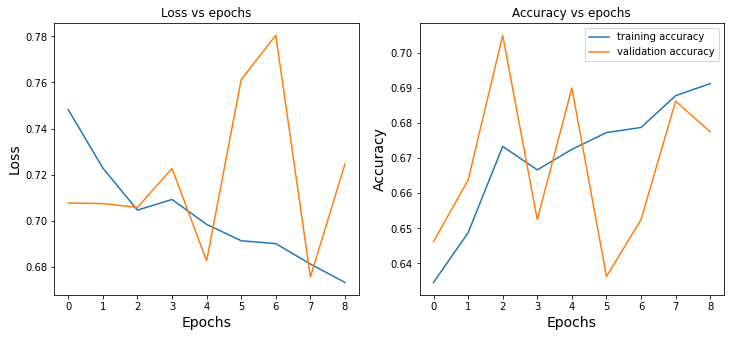

In [20]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(his.history['loss'], label = 'training loss')
axes[0].plot(his.history['val_loss'], label = 'validation loss')

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(his.history['accuracy'], label = 'training accuracy')
axes[1].plot(his.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

ROC-AUC curve

In [ ]:
prediction = model.predict(x_test)
pred = [i[0] for i in prediction]

In [ ]:
from sklearn import metrics
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, pred)
auc_rf = metrics.auc(fpr_rf, tpr_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='mobilenet (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
model.save('nih_models/mobilenetv2_update_aug.h5')

Resnet model without skip connections

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
model1 = load_model('nih_models/mobilenetv2.h5', custom_objects = {'KerasLayer': hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4")})


In [ ]:
model1.summary()

In [ ]:
model1.evaluate(test_dataset)

In [ ]:
his = model1.fit(train_dataset, validation_data = valid_dataset, epochs=15, verbose=1)